In [1]:
import pandas as pd
import matplotlib as plt
import numpy as np
import os
import statsmodels.api as sm
from scipy import stats
import seaborn as sns
import glob

#the following function takes merges n cuffdiff files in your folder
def merge_tables(genefile):
    spath = os.getcwd()
    gene_id = pd.read_csv(genefile)
    for root, dirs, filenames in os.walk(spath):
        for f in filenames:
            if f.endswith('gene_exp.diff'):
                x = pd.read_table(os.path.join(root, f))
                x = x.rename(columns={ x.columns[9]: "logFC" })
                y = os.path.basename(root)
                x.columns = [str(col) + '_' + y for col in x.columns]
                x = x.rename(columns={ x.columns[0]: "test_id" })
                gene_id = gene_id.merge((x), on = 'test_id', how = 'outer')
    return gene_id

# FPKM restriction restricts the genes considered to only those above 1 FPKM
def FPKM_restriction(transcriptome, FPKM_cutoff):
    vals = []   
    cols = list(transcriptome.columns)
    for i,y in enumerate(cols):
        if 'value' in y:
            vals.append(y)
        for z in vals:    
            if 'p_value' in z:
                vals.remove(z)
            if 'q_value' in z:
                vals.remove(z)
    for q in vals:  
        transcriptome = transcriptome[transcriptome[q] >= FPKM_cutoff] 
    return transcriptome

# splits decimal portion of gene ID for merging
def split_gene_ID(x):
    new_IDs = x
    new = new_IDs["gene_id"].str.partition(".")
    new.columns = ['gene_id','.','decimal']
    new_IDs['gene_id'] = new['gene_id']
    return new_IDs

# merges metrics files in metrics folder
def merge_metrics(d):
    for file in glob.glob("METRICS/*"):
        if file.endswith('.txt'):
            file = pd.read_table(file)
            file = file.rename(columns={ file.columns[0]: "gene_id" })
            d = d.merge((file), on = 'gene_id', how = 'inner')
        elif file.endswith('.csv'): 
            file = pd.read_csv(file)
            file = file.rename(columns={ file.columns[0]: "gene_id" })
            d = d.merge((file), on = 'gene_id', how = 'inner')
    return d


In [2]:
transcriptome = merge_tables('geneNames.csv')
transcriptome['logFC_SG'] = pd.to_numeric(transcriptome['logFC_SG'], errors = 'coerce')

#changes fold change values to the correct sign
for x in transcriptome.columns:
    if 'logFC' in x:
        transcriptome[x] = transcriptome[x]*-1
    

In [19]:
transcriptome = split_gene_ID(transcriptome)
transcriptome = merge_metrics(transcriptome)
transcriptome.to_csv('/Users/tyler-matheny/Desktop/new.csv')

/Users/tyler-matheny/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


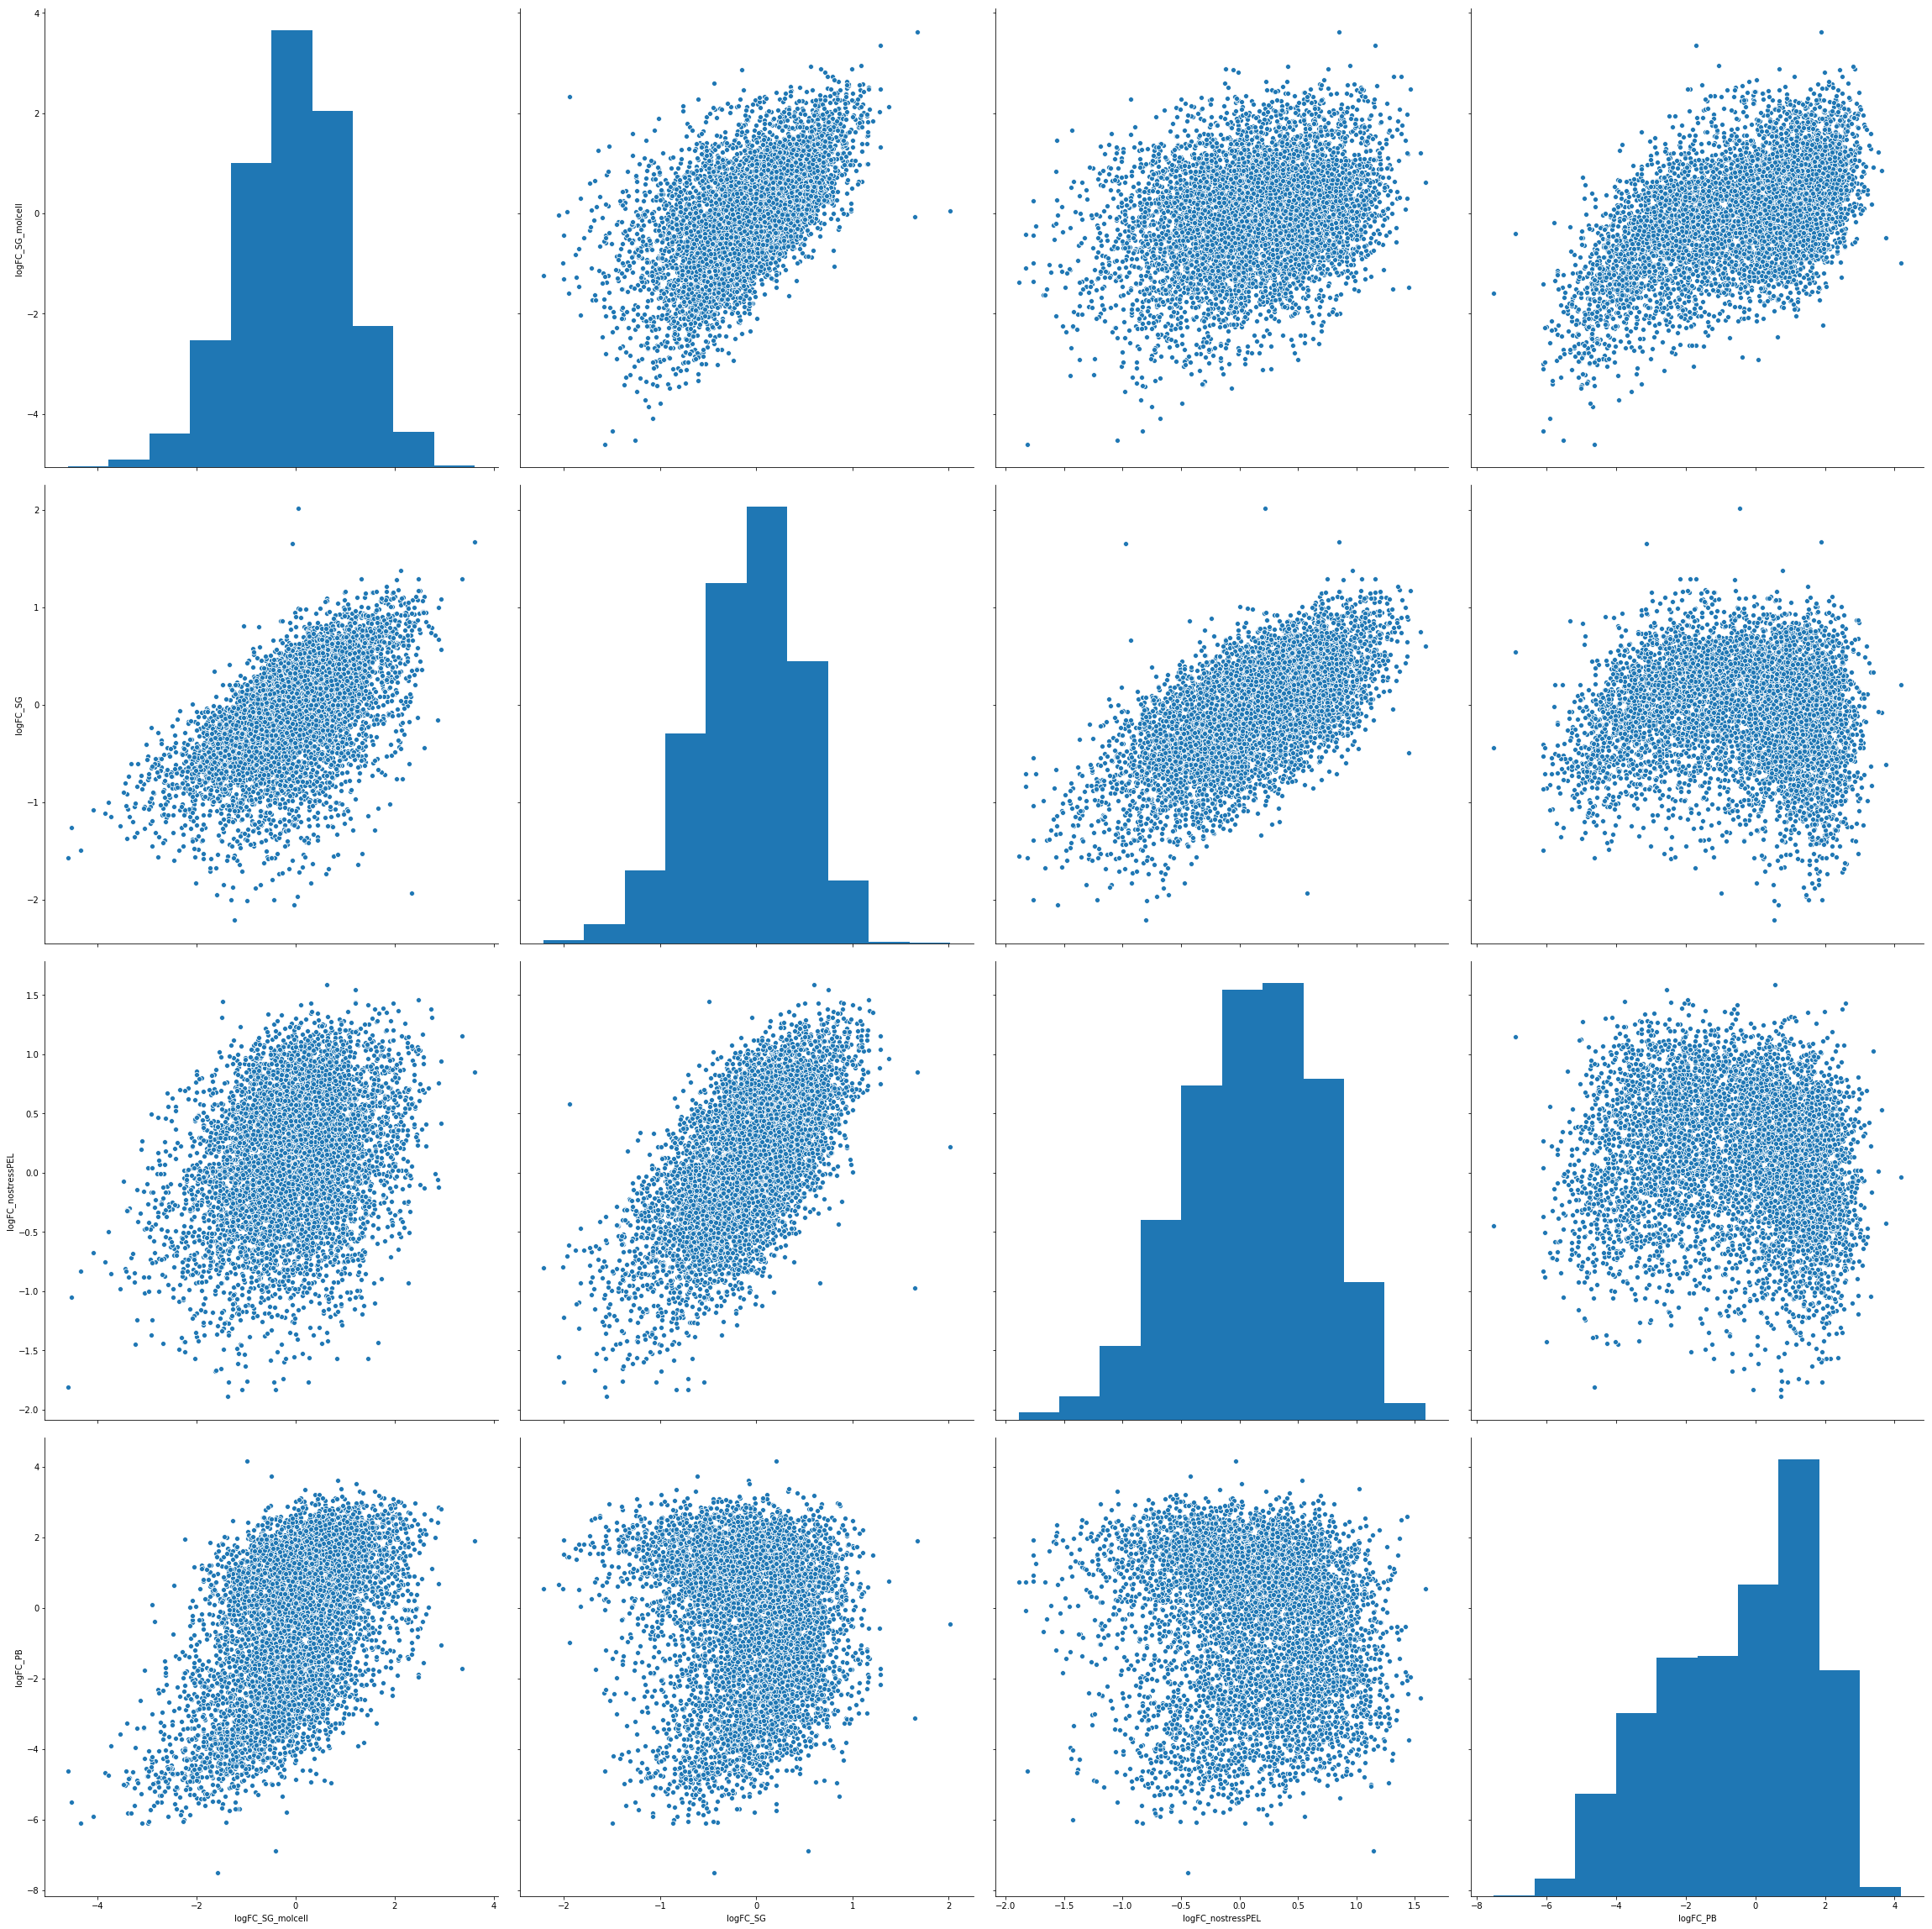

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
correlation_matrix = transcriptome[['logFC_PB', 'logFC_SG_molcell', 'logFC_SG', 'logFC_nostressPEL', 'value_2_PB','value_2_SG', 'value_2_SG_molcell', 'value_2_nostressPEL']]
correlation_matrix = FPKM_restriction(correlation_matrix, 1)
correlation_matrix = correlation_matrix[[ 'logFC_SG_molcell', 'logFC_SG', 'logFC_nostressPEL','logFC_PB']]
correlation_matrix = correlation_matrix.apply(pd.to_numeric, errors = 'coerce')
correlation_matrix = correlation_matrix.replace([np.inf, -np.inf], np.nan)
correlation_matrix = correlation_matrix.dropna()
new_plot = sns.pairplot(correlation_matrix, size = 8)

new_plot.savefig('/Users/tyler-matheny/Desktop/pairplot.png', dpi =400)

In [4]:
transcriptome = merge_tables('geneNames.csv')
transcriptome['logFC_SG'] = pd.to_numeric(transcriptome['logFC_SG'], errors = 'coerce')

#changes fold change values to the correct sign
for x in transcriptome.columns:
    if 'logFC' in x:
        transcriptome[x] = transcriptome[x]*-1

transcriptome = split_gene_ID(transcriptome)
transcriptome = merge_metrics(transcriptome)

HELA = pd.read_table('TE_HELA.txt')
transcriptome['Gene name'] = transcriptome['gene_PB']
transcriptome = transcriptome.merge(HELA, how = 'inner', on = 'Gene name')

transcriptome['logFC_SG'] = transcriptome['logFC_SG'].apply(pd.to_numeric, errors='coerce')
transcriptome['localization_SG'] = transcriptome['logFC_SG'].map(lambda x: 'enriched_SG' if x > 0 else 'depleted_stress')
TEs_SG_enriched = transcriptome[['log2(TE)HELA','localization_SG', 'value_2_SG']]
TEs_SG_enriched = FPKM_restriction(TEs_SG_enriched, 1)
TEs_SG_enriched = TEs_SG_enriched[['log2(TE)HELA','localization_SG']]

transcriptome['logFC_nostressPEL'] = transcriptome['logFC_nostressPEL'].apply(pd.to_numeric, errors='coerce')
transcriptome['localization_nostressPEL'] = transcriptome['logFC_nostressPEL'].map(lambda x: 'enriched_nostress' if x > 0 else 'depleted_nostress')
TEs_nostressPEL_enriched = transcriptome[['log2(TE)HELA','localization_nostressPEL', 'value_2_nostressPEL']]
TEs_nostressPEL_enriched = FPKM_restriction(TEs_nostressPEL_enriched, 1)
TEs_nostressPEL_enriched = TEs_nostressPEL_enriched[['log2(TE)HELA','localization_nostressPEL']]


TEs_SG_enriched.columns = ['TE', 'localization']
TEs_nostressPEL_enriched.columns = ['TE', 'localization']
frames = [TEs_SG_enriched, TEs_nostressPEL_enriched]
TEs = pd.concat(frames)

import seaborn as sns
import matplotlib.pyplot as plt
new_plot = sns.boxplot(x="TE", y="localization", data=TEs, palette = 'Paired', order = ('depleted_stress', 'enriched_SG', 'depleted_nostress', 'enriched_nostress'))
plt.xlim(-4, 4)
figure = new_plot.get_figure()
figure.savefig('/Users/tyler-matheny/Desktop/boxplot.png', dpi =400)

#transcriptome['logFC_nostressPEL'] = transcriptome['logFC_nostressPEL'].apply(pd.to_numeric, errors='coerce')

#enriched_nostressPEL = transcriptome[transcriptome.logFC_nostressPEL > 0]
#TEs_nostressPEL_enriched = enriched_nostressPEL['log2(TE)']
#type(TEs_SG_enriched)

In [5]:
transcriptome = merge_tables('geneNames.csv')
transcriptome['logFC_SG'] = pd.to_numeric(transcriptome['logFC_SG'], errors = 'coerce')

#changes fold change values to the correct sign
for x in transcriptome.columns:
    if 'logFC' in x:
        transcriptome[x] = transcriptome[x]*-1

transcriptome = split_gene_ID(transcriptome)
transcriptome = merge_metrics(transcriptome)

HELA = pd.read_table('TE_HELA.txt')
transcriptome['Gene name'] = transcriptome['gene_PB']
transcriptome = transcriptome.merge(HELA, how = 'inner', on = 'Gene name')

transcriptome['logFC_SG'] = transcriptome['logFC_SG'].apply(pd.to_numeric, errors='coerce')
transcriptome['localization_SG'] = transcriptome['logFC_SG'].map(lambda x: 'enriched_SG' if x > 0 else 'depleted_stress')
TEs_SG_enriched = transcriptome[['Transcript length (including UTRs and CDS)','localization_SG', 'value_2_SG']]
TEs_SG_enriched = FPKM_restriction(TEs_SG_enriched, 1)
TEs_SG_enriched = TEs_SG_enriched[['Transcript length (including UTRs and CDS)','localization_SG']]

transcriptome['logFC_nostressPEL'] = transcriptome['logFC_nostressPEL'].apply(pd.to_numeric, errors='coerce')
transcriptome['localization_nostressPEL'] = transcriptome['logFC_nostressPEL'].map(lambda x: 'enriched_nostress' if x > 0 else 'depleted_nostress')
TEs_nostressPEL_enriched = transcriptome[['Transcript length (including UTRs and CDS)','localization_nostressPEL', 'value_2_nostressPEL']]
TEs_nostressPEL_enriched = FPKM_restriction(TEs_nostressPEL_enriched, 1)
TEs_nostressPEL_enriched = TEs_nostressPEL_enriched[['Transcript length (including UTRs and CDS)','localization_nostressPEL']]


TEs_SG_enriched.columns = ['transcript length', 'localization']
TEs_nostressPEL_enriched.columns = ['transcript length', 'localization']
frames = [TEs_SG_enriched, TEs_nostressPEL_enriched]
TEs = pd.concat(frames)

import seaborn as sns
import matplotlib.pyplot as plt
new_plot = sns.boxplot(x="transcript length", y="localization", data=TEs, palette = 'Paired', order = ('depleted_stress', 'enriched_SG', 'depleted_nostress', 'enriched_nostress'))
plt.xlim(-1000, 12500)
figure = new_plot.get_figure()
figure.savefig('/Users/tyler-matheny/Desktop/boxplot.png', dpi =400)



In [15]:
HEK = pd.read_table('TE_HEK.txt')
transcriptome['Gene name'] = transcriptome['gene_PB']
transcriptome = transcriptome.merge(HEK, how = 'inner', on = 'Gene name')
highly_expressed = FPKM_restriction(transcriptome, 1)
transcriptome['logFC_SG_molcell'] = transcriptome['logFC_SG_molcell'].apply(pd.to_numeric, errors='coerce')
transcriptome
enriched_molcell = transcriptome[transcriptome.logFC_SG_molcell > 0]
TEs = enriched_molcell['log2(TE)']
TEs

4       0.038525
5       1.695166
6      -0.448678
8      -0.480995
9      -1.709814
10     -1.316247
14     -0.044706
15     -0.363029
17      0.863124
19     -0.992544
22      0.874400
23     -0.607489
30      2.081178
32      0.781845
33      0.623406
34      0.502030
35      0.503393
37     -0.897896
38      1.976114
42     -1.591339
46     -1.373281
48      1.043617
52      1.546334
53     -0.808178
54     -0.255257
56     -0.136603
58     -1.151488
63      0.177266
64      0.028151
65      0.816982
          ...   
5550    0.326432
5551    0.662145
5553    0.236298
5555    0.221253
5560   -2.282554
5564   -0.874717
5566    0.605508
5575    0.989401
5576   -1.282587
5584    0.717741
5592    1.690009
5598   -0.122484
5602   -0.386284
5607    0.095779
5613   -0.448300
5614   -0.124054
5628    0.112538
5629   -1.319545
5631   -0.308088
5633    0.667903
5634    0.881766
5639   -0.011819
5643    2.031921
5645   -0.795780
5646   -0.477047
5647    1.089341
5648    0.128914
5657    0.4575

In [9]:
plot_data = transcriptome[['logFC_SG','neg_log_p-value_SG']]

KeyError: "['neg_log_p-value_SG'] not in index"

In [10]:
transcriptome.columns

Index(['Unnamed: 0', 'test_id', 'gene_id', 'gene_id_WTPBODY', 'gene_WTPBODY',
       'locus_WTPBODY', 'sample_1_WTPBODY', 'sample_2_WTPBODY',
       'status_WTPBODY', 'value_1_WTPBODY',
       ...
       'DDX55', 'MBNL2', 'DROSHA', 'DDX42', 'CAPRIN1',
       'Transcript length (including UTRs and CDS)', 'Gene name',
       'log2(TE)HELA', 'localization_SG', 'localization_nostressPEL'],
      dtype='object', length=178)

In [17]:
new = transcriptome[['logFC_nostressPEL', 'logFC_SG', 'logFC_PB', 'value_2_nostressPEL', 'value_2_SG','Transcript length (including UTRs and CDS)', 'log2(TE)HELA']]
new = FPKM_restriction(new, 1)
new = new.drop_duplicates()
X_metrics = new[['logFC_nostressPEL','logFC_SG','log2(TE)HELA','Transcript length (including UTRs and CDS)']]
X_metrics = X_metrics.replace([np.inf, -np.inf], np.nan)
X_metrics = X_metrics.apply(pd.to_numeric, errors='coerce')
X_metrics = X_metrics.dropna()
#X_metrics_new = X_metrics['logFC_SG_molcell']
X_metrics_new = X_metrics[['logFC_nostressPEL','log2(TE)HELA','Transcript length (including UTRs and CDS)']]
Y_metrics = X_metrics['logFC_SG']

In [18]:
est = sm.OLS(Y_metrics, X_metrics_new)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:               logFC_SG   R-squared:                       0.540
Model:                            OLS   Adj. R-squared:                  0.540
Method:                 Least Squares   F-statistic:                     2451.
Date:                Tue, 19 Mar 2019   Prob (F-statistic):               0.00
Time:                        14:42:12   Log-Likelihood:                -2674.5
No. Observations:                6274   AIC:                             5355.
Df Residuals:                    6271   BIC:                             5375.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------

In [27]:
new = transcriptome[['logFC_SG_molcell','logFC_nostressPEL', 'value_2_SG_molcell','logFC_SG', 'logFC_PB', 'value_2_PB', 'Gene % GC content']]
new = FPKM_restriction(new, 1)
new = new.drop_duplicates()
X_metrics = new[['logFC_SG_molcell', 'logFC_PB','logFC_nostressPEL','logFC_SG','Gene % GC content']]
X_metrics = X_metrics.replace([np.inf, -np.inf], np.nan)
X_metrics = X_metrics.apply(pd.to_numeric, errors='coerce')
X_metrics = X_metrics.dropna()
#X_metrics_new = X_metrics['logFC_SG_molcell']
X_metrics_new = X_metrics['logFC_SG_molcell']
Y_metrics = X_metrics['logFC_SG']

In [28]:

est = sm.OLS(Y_metrics, X_metrics_new)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:               logFC_SG   R-squared:                       0.351
Model:                            OLS   Adj. R-squared:                  0.351
Method:                 Least Squares   F-statistic:                     2913.
Date:                Mon, 11 Mar 2019   Prob (F-statistic):               0.00
Time:                        21:07:35   Log-Likelihood:                -3288.5
No. Observations:                5393   AIC:                             6579.
Df Residuals:                    5392   BIC:                             6586.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
logFC_SG_molcell     0.3040      0.006  

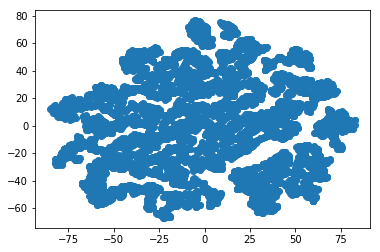

In [66]:
# Importing Modules
from sklearn import datasets
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt



# Defining Model
model = TSNE(learning_rate=100)

# Fitting Model
transformed = model.fit_transform(X_metrics_new)

# Plotting 2d t-Sne
x_axis = transformed[:, 0]
y_axis = transformed[:, 1]

plt.scatter(x_axis, y_axis)
plt.show()

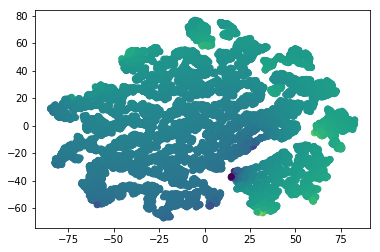

In [67]:
z = X_metrics_new['logFC_SG_molcell'] - X_metrics_new['logFC_PB']
plt.scatter(x_axis, y_axis, c= z)
plt.show()


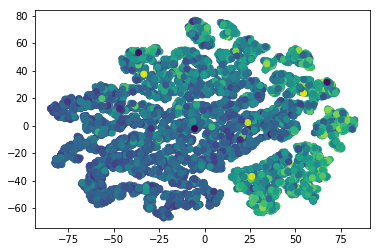

In [68]:
z = X_metrics['Gene % GC content']
plt.scatter(x_axis, y_axis, c= z)
plt.show()


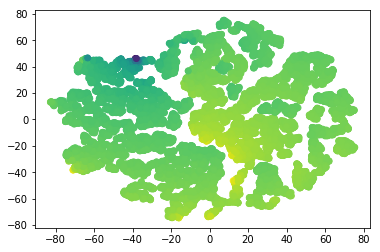

In [61]:
z = X_metrics['logFC_SG_molcell'] 
plt.scatter(x_axis, y_axis, c= z)
plt.show()

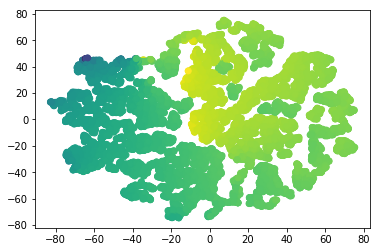

In [57]:
z = X_metrics['logFC_PB'] 
plt.scatter(x_axis, y_axis, c= z)
plt.show()

In [32]:
import plotly.plotly as py
import plotly.graph_objs as go
import numpy as np
transcriptome = FPKM_restriction(transcriptome, .5)

x = transcriptome['logFC_SG_molcell']
y = transcriptome['logFC_PB']

c = transcriptome['Gene % GC content']


import plotly.graph_objs as go
import plotly.plotly as py

import numpy as np

trace1 = go.Scatter(
    x=x,
    y=y,
    mode='markers',
    marker=dict(
        size=2,
        color = c, #set color equal to a variable
        colorscale='Viridis',
        showscale=True
    )
)
data = [trace1]

py.iplot(data, filename='scatter-plot-with-colorscale')

In [9]:
transcriptome.to_csv('/Users/tyler-matheny/Desktop/finalmerge.csv')

In [ ]:
for x in transcriptome.columns:
    if 'logFC' in x:
        transcriptome[x] = transcriptome[x]*-1
        

In [ ]:
pd.set_option('display.max_columns', 500)
transcriptome
#transcriptome.to_csv('/Users/tyler-matheny/Desktop/newstuff.csv')

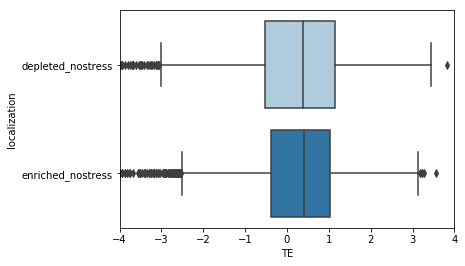

In [16]:
%matplotlib inline
transcriptome = merge_tables('geneNames.csv')
transcriptome['logFC_SG'] = pd.to_numeric(transcriptome['logFC_SG'], errors = 'coerce')

#changes fold change values to the correct sign
for x in transcriptome.columns:
    if 'logFC' in x:
        transcriptome[x] = transcriptome[x]*-1

transcriptome = split_gene_ID(transcriptome)
transcriptome = merge_metrics(transcriptome)

HELA = pd.read_table('TE_HELA.txt')
transcriptome['Gene name'] = transcriptome['gene_PB']
transcriptome = transcriptome.merge(HELA, how = 'inner', on = 'Gene name')

transcriptome['logFC_SG'] = transcriptome['logFC_SG'].apply(pd.to_numeric, errors='coerce')
transcriptome['localization_SG'] = transcriptome['logFC_SG'].map(lambda x: 'enriched_SG' if x > 0 else 'depleted_stress')
TEs_SG_enriched = transcriptome[['log2(TE)HELA','localization_SG', 'value_2_SG']]
TEs_SG_enriched = FPKM_restriction(TEs_SG_enriched, 1)
TEs_SG_enriched = TEs_SG_enriched[['log2(TE)HELA','localization_SG']]

transcriptome['logFC_nostressPEL'] = transcriptome['logFC_nostressPEL'].apply(pd.to_numeric, errors='coerce')
transcriptome['localization_nostressPEL'] = transcriptome['logFC_nostressPEL'].map(lambda x: 'enriched_nostress' if x > 0 else 'depleted_nostress')
TEs_nostressPEL_enriched = transcriptome[['log2(TE)HELA','localization_nostressPEL', 'value_2_nostressPEL']]
TEs_nostressPEL_enriched = FPKM_restriction(TEs_nostressPEL_enriched, 1)
TEs_nostressPEL_enriched = TEs_nostressPEL_enriched[['log2(TE)HELA','localization_nostressPEL']]


TEs_SG_enriched.columns = ['TE', 'localization']
TEs_nostressPEL_enriched.columns = ['TE', 'localization']
frames = [TEs_SG_enriched, TEs_nostressPEL_enriched]
TEs = pd.concat(frames)

import seaborn as sns
import matplotlib.pyplot as plt
new_plot = sns.boxplot(x="TE", y="localization", data = TEs_nostressPEL_enriched, palette = 'Paired', order = ('depleted_nostress', 'enriched_nostress'))
plt.xlim(-4, 4)
figure = new_plot.get_figure()
figure.savefig('/Users/tyler-matheny/Desktop/boxplot.png', dpi =400)

#transcriptome['logFC_nostressPEL'] = transcriptome['logFC_nostressPEL'].apply(pd.to_numeric, errors='coerce')

#enriched_nostressPEL = transcriptome[transcriptome.logFC_nostressPEL > 0]
#TEs_nostressPEL_enriched = enriched_nostressPEL['log2(TE)']
#type(TEs_SG_enriched)

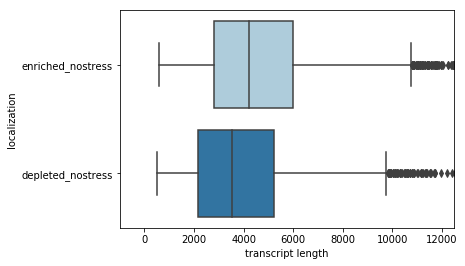

In [21]:
transcriptome = merge_tables('geneNames.csv')
transcriptome['logFC_SG'] = pd.to_numeric(transcriptome['logFC_SG'], errors = 'coerce')

#changes fold change values to the correct sign
for x in transcriptome.columns:
    if 'logFC' in x:
        transcriptome[x] = transcriptome[x]*-1

transcriptome = split_gene_ID(transcriptome)
transcriptome = merge_metrics(transcriptome)

HELA = pd.read_table('TE_HELA.txt')
transcriptome['Gene name'] = transcriptome['gene_PB']
transcriptome = transcriptome.merge(HELA, how = 'inner', on = 'Gene name')

transcriptome['logFC_SG'] = transcriptome['logFC_SG'].apply(pd.to_numeric, errors='coerce')
transcriptome['localization_SG'] = transcriptome['logFC_SG'].map(lambda x: 'enriched_SG' if x > 0 else 'depleted_stress')
TEs_SG_enriched = transcriptome[['Transcript length (including UTRs and CDS)','localization_SG', 'value_2_SG']]
TEs_SG_enriched = FPKM_restriction(TEs_SG_enriched, 1)
TEs_SG_enriched = TEs_SG_enriched[['Transcript length (including UTRs and CDS)','localization_SG']]

transcriptome['logFC_nostressPEL'] = transcriptome['logFC_nostressPEL'].apply(pd.to_numeric, errors='coerce')
transcriptome['localization_nostressPEL'] = transcriptome['logFC_nostressPEL'].map(lambda x: 'enriched_nostress' if x > 0 else 'depleted_nostress')
TEs_nostressPEL_enriched = transcriptome[['Transcript length (including UTRs and CDS)','localization_nostressPEL', 'value_2_nostressPEL']]
TEs_nostressPEL_enriched = FPKM_restriction(TEs_nostressPEL_enriched, 1)
TEs_nostressPEL_enriched = TEs_nostressPEL_enriched[['Transcript length (including UTRs and CDS)','localization_nostressPEL']]


TEs_SG_enriched.columns = ['transcript length', 'localization']
TEs_nostressPEL_enriched.columns = ['transcript length', 'localization']
frames = [TEs_SG_enriched, TEs_nostressPEL_enriched]
TEs = pd.concat(frames)

import seaborn as sns
import matplotlib.pyplot as plt
new_plot = sns.boxplot(x="transcript length", y="localization", data = TEs_nostressPEL_enriched, palette = 'Paired')
plt.xlim(-1000, 12500)
figure = new_plot.get_figure()
figure.savefig('/Users/tyler-matheny/Desktop/boxplot.png', dpi =400)
